# First implementation from Julia

In [ ]:
import networkx as nx
from scipy.stats import binom
import numpy as np
from statistics import mean

In [20]:
ALPHA_PROB = 0.5
BETA_PROB = 0.6

def get_evidence(conf, nr_trials):
    if conf > 0.5:
        return np.random.binomial(nr_trials, BETA_PROB) / nr_trials
    else:
        return np.random.binomial(nr_trials, ALPHA_PROB) / nr_trials

    
def update_confidence(conf, evidences):
    new_confidence = np.mean([conf, np.mean(evidences)])
    return new_confidence
    
    
class DEpiNet:
    def __init__(self, net, conf_mean, conf_sd):
        self.structure = net
        confidences = np.random.normal(conf_mean, conf_sd, len(self.structure.nodes))
        for i in range(len(self.structure.nodes)):
            self.structure.nodes[i]['confidence'] = confidences[i]

In [21]:
G = nx.complete_graph(10)

In [22]:
from netwulf import visualize

({'xlim': [0, 926],
  'ylim': [0, 926],
  'linkColor': '#0010ff',
  'linkAlpha': 0.5886488076685994,
  'nodeStrokeColor': '#000000',
  'nodeStrokeWidth': 4.657599442008211,
  'links': [],
  'nodes': [{'id': 0,
    'x': 466.03178696857054,
    'y': 483.0199243919848,
    'x_canvas': 486.16506833088624,
    'y_canvas': 615.9668546395792,
    'radius': 38.669276800454185,
    'color': '#b60017'},
   {'id': 1,
    'x': 437.9640298112636,
    'y': 506.93153661475594,
    'x_canvas': 271.70688931499944,
    'y_canvas': 798.6690486869766,
    'radius': 38.669276800454185,
    'color': '#b60017'},
   {'id': 2,
    'x': 441.8115707740617,
    'y': 420.35862009936625,
    'x_canvas': 301.10491438505414,
    'y_canvas': 137.1886915665491,
    'radius': 38.669276800454185,
    'color': '#b60017'},
   {'id': 3,
    'x': 512.4632960638706,
    'y': 477.41378445496713,
    'x_canvas': 840.9357339644007,
    'y_canvas': 573.1318480709101,
    'radius': 38.669276800454185,
    'color': '#b60017'},
   {

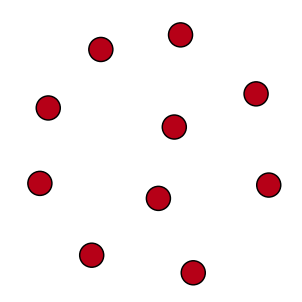

In [28]:
visualize(G)

In [24]:
network = DEpiNet(G, 0.5, 0.2)

In [25]:
[network.structure.nodes[i]['confidence'] for i in range(len(network.structure.nodes))]

[0.8864565916920135,
 0.4047457320412138,
 0.6019640501772138,
 0.2549956127067011,
 0.7292998988111432,
 0.3392581575017422,
 0.4352945148342429,
 1.0559991372218458,
 0.5645845514870133,
 0.20324717381616547]

In [26]:
network.structure.nodes[0]

{'confidence': 0.8864565916920135}

In [27]:
for step in range(5):
    new_net = network.structure.copy()
    
    # Posess evidences
    for i in range(len(network.structure.nodes)):
        network.structure.nodes[i]['evidence'] = get_evidence(
            network.structure.nodes[i]['confidence'], 10
        )

    # Update confidences
    for i in range(len(network.structure.nodes)):
        evidences = [network.structure.nodes[i]['evidence'] for i in list(network.structure.neighbors(1))]
        new_net.nodes[i]['confidence'] = update_confidence(
            conf=network.structure.nodes[i]['confidence'],
            evidences=evidences
        )
    network.structure = new_net

In [75]:
list(G.neighbors(1))

[0, 2, 3, 4, 5, 6, 7, 8, 9]

In [88]:
[network.structure.nodes[i]['confidence'] for i in range(len(network.structure.nodes))]

[0.6248643119821027,
 0.6248619458583066,
 0.6248663177508998,
 0.6248662020309907,
 0.624865955206311,
 0.6248613758784693,
 0.6248671639098549,
 0.624859689824347,
 0.6248694289272857,
 0.6248537419992493]

# Epistemic Network Model

## Notes

### Model

The basic setup of Bala and Goyal’s model is that there is **a group
of simple agents** — highly idealized representations of scientists, or
knowledge seekers — who are **trying to choose between two actions**
and who use information gathered by themselves and by others to
make this choice. The two actions are assumed to differ in how
likely they are to yield a desired outcome. This could represent the
choice between eating fish or not and so increasing or decreasing
one’s risk of mercury poisoning; or it could be regulating smokestack
emissions and so increasing or decreasing the risks of acid rain.
For a very simple example, imagine someone faced with two slot
machines, trying to figure out which one pays out more often.  

Over a series of rounds, each scientist in the model chooses one
action or the other. They **make their choices on the basis of what
they currently believe about the problem, and they record the results
of their actions.** To begin with, the scientists are not sure about
which action is more likely to yield the desired outcome. But as they
make their choices, they gradually see what sorts of outcomes each
action yields. These **outcomes are the evidence they use to update
their beliefs.** Importantly, each scientist develops beliefs based not
only on the outcomes of their own actions, but also on those of
their colleagues and friends.  

We have an abstract
network consisting of a collection of “nodes,” each of which may or
may not be connected to other nodes by what is called an “edge.” Each node represents a scientist, and each edge connects two scientists
who have access to each other’s results.
These networks can take different shapes. **These structures are often important in determining how information
and ideas flow through a group.**

We should also emphasize that, although our examples come
from science and we are calling the agents in our model “scientists,”
these models can represent any group of people who are trying to
make their way in an unpredictable world. All of us act as scientists
sometimes, when we make decisions based on our own experiences
and those of our friends. Ever buy a car? There is a good chance
that you took it for a test drive and asked the dealer some questions.
You were gathering evidence before making a decision.


### Agents (Scientists)
In the model,
each node — each scientist — is associated with a number between 0
and 1. This number represents the scientist’s level of certainty, or
credence, that action B is better than action A. An assignment of .7
would mean that particular scientist thinks there is a 70 percent
chance that action B is better than action A. Which action the scientist
takes is wholly determined by this number. If it is greater
than .5, the scientist performs action B — by which we mean that we
simulate pulling a slot machine some number of times and counting
the number of times it pays off. Then we use Bayes’ rule to
update the scientist’s credence in light of this result, and likewise
update the credences of all of the other neighboring scientists on
the network.
If the scientist’s belief is less than .5, he or she performs action
A. In the simplest version of the model, we assume that everyone
knows that this action works exactly half the time. (When credences exactly equal .5, we also have the agent choose action A, but
this essentially never happens.) **Any
one
connected to someone who tried action B—the new, unknown
treatment—will update their beliefs.**  

**This process continues stepwise (try actions, update credences,
try actions, update credences) until the scientists have converged on
a consensus.** This can happen if all of the scientists have sufficiently
high credence—greater than .99—that action B is better; or all of them have sufficiently low credence, less than .5, so that no one in
the network ever performs action B, in which case they will not
learn anything further about it. In the first case, we say the network
has converged to the true belief. In the second, we say it has converged
to the false one.  

In general, these models tend to converge
to the true consensus—that is, the whole network comes to believe
that action B is better. But sometimes go to the
false one.22
What we want to understand is this: **Under what circumstances
do networks of scientists converge to false beliefs?**



### Actions
In the model, one of the two actions — call it action B — is, in fact,
better than action A. (To keep this straight, remember that A is for
“All right,” but B is for “Better.”) But figuring out which action is
superior is not necessarily easy. **A crucial assumption in this model
is that evidence is probabilistic**, meaning that when the scientists
investigate the world — test a slot machine or warn a sick patient off
fish — the results are not always the same. **Action B is better than
action A because, on average, it yields better results.** But there can
be many individual instances when action A happens to yield a better
result.
In this way, we can think of action B as similar to a biased coin.
It may land heads up more often than an ordinary coin — but that
does not mean that it never lands tails up. And if you flip a biased
coin and an unbiased coin some number of times, there is no guarantee
that the biased one will land heads up more often. It is merely
likely that it will do so.


### Zollman effect
This trade-off, where connections propagate true beliefs but
also open channels for the spread of misleading evidence, means
that sometimes it is actually better for a group of scientists to communicate
less, especially when they work on a hard problem. This
phenomenon, in which scientists improve their beliefs by failing to
communicate, is known as the “Zollman effect,” after Kevin Zollman,
who discovered it.28 If everybody shares evidence, a chance
string of bad data can persuade the entire group to abandon the
correct theory. But in a group where not everyone listens to everyone
else, pockets of scientists can be protected from misleading
data and continue to gather evidence on the true belief that eventually
persuades the rest of the community.


### Network structure remarks
1. Real human networks are often “small worlds,” which tend to have interconnected
cliques and short path lengths between any two nodes. Granovetter
(1973) conceived of human networks as consisting of tight-knit cliques connected
by bridges. Watts and Strogatz (1998) developed their famous “small
world” networks to try to capture realistic aspects of human networks. Onnela
et al. (2007) observe such structures among cell phone users. Newman
(2001) finds the same for scientific collaboration networks.
2. The harder the problem, the more potential social structure has to
influence the outcome. (Zollman effect; Rosenstock, Bruner, and O’Connor (2016) show that Zollman’s research on
connectivity and consensus is sensitive to parameter values and that, in particular,
in communities where scientists gather large data sets and data is more reliable, it is better to always communicate this data)


### Other remarks
1. The social spread of knowledge is a double-edged sword. It gives us
remarkable capabilities, as a species, to develop sophisticated knowledge
about the world, but it also opens the door to the spread of
false belief.

## Usage example

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cd ..

C:\Users\Damian\Studia\Danologia\Magisterka\depinet\DEpiNet


In [46]:
from src.epinet.agent import Agent
from src.epinet.models import Network, DynamicNetwork
from src.epinet.simulation import Simulation

### Agent

In [42]:
a = Agent('1', 0.5, [])
print(f'Base credence: {a.credence}')
a.update_credence(10, 6)
print(f'Credence after update: {a.credence}')

Base credence: 0.5
Credence after update: 0.6923076923076922


### Static Network

Graph edges: {0: [1, 2], 1: [0], 2: [0]}
Consensus check: False


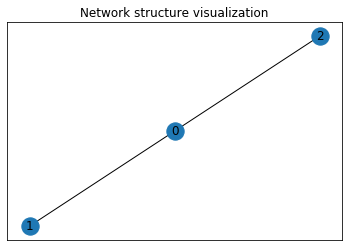

In [43]:
import networkx as nx

# Create craph structure
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2)])
l = nx.convert.to_dict_of_lists(G)
print(f'Graph edges: {l}')

# Create epostemic network
g = Network(l)
print(f'Consensus check: {g.is_consensus()}')
g.plot('Network structure visualization')

### Dynamic Network

Graph edges:
 - Step 1: {0: [1, 2], 1: [0], 2: [0, 3], 3: [2]}
 - Step 2: {0: [1, 2], 1: [0, 2], 2: [0, 3, 1], 3: [2]}
 - Step 3: {0: [1, 2, 3], 1: [0, 2], 2: [0, 3, 1], 3: [2, 0]}


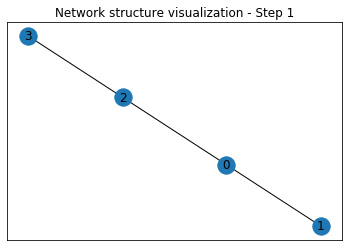

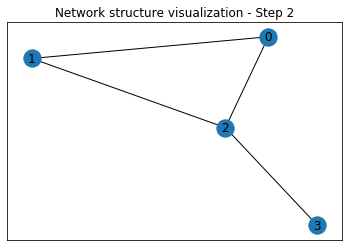

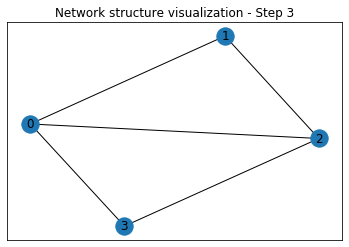

In [44]:
import networkx as nx

# Create craph structure
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (2, 3)])
l1 = nx.convert.to_dict_of_lists(G)

G.add_edges_from([(1, 2)])
l2 = nx.convert.to_dict_of_lists(G)

G.add_edges_from([(0, 3)])
l3 = nx.convert.to_dict_of_lists(G)

print('Graph edges:')
print(f' - Step 1: {l1}')
print(f' - Step 2: {l2}')
print(f' - Step 3: {l3}')

# Create epostemic network
g = DynamicNetwork(l1)
g.plot('Network structure visualization - Step 1')
g.update_structure(l2)
g.plot('Network structure visualization - Step 2')
g.update_structure(l3)
g.plot('Network structure visualization - Step 3')

### Simulation

In [45]:
# Create epistemic network
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 3), (3, 4), (2, 5), (5, 6)])
l = nx.convert.to_dict_of_lists(G)
g = Network(l)
print(f'Consensus check: {g.is_consensus()}')

# Run simulation
s = Simulation(g, 10)
sim_res = s.run()
if sim_res:
    print('Consensus reached')
else:
    print('No consensus')

Consensus check: False
Consensus reached


### Zollman effect

In [ ]:
# TODO: run

### Cogsnet based

## Implementation

In [32]:
import networkx as nx
from numpy import random
from typing import Dict, List

class Agent:
    BASE_ACTION_PAYOFF = 0.5
    EPSILON = 0.001
    BETA_ACTION_PAYOFF = BASE_ACTION_PAYOFF + EPSILON
    
    def __init__(self, i, credence, neighbors):
        self.id = i
        self.credence = credence
        self.neighbors = neighbors
        self.n = 0
        self.k = 0
        
    def get_evidence(self, n_trials):
        self.n, self.k = 0, 0
        if self.credence > self.BASE_ACTION_PAYOFF:
            self.n = n_trials
            self.k = random.binomial(n_trials, self.BETA_ACTION_PAYOFF)

    def update_credence(self, n, k):
        #n = self.n + sum([neighbor.n for neighbor in self.neighbors])
        #k = self.k + sum([neighbor.k for neighbor in self.neighbors])
        self.credence = 1 / (1 + (1 - self.credence) * (((0.5 - self.EPSILON) / (0.5 + self.EPSILON)) ** (2 * k - n)) / self.credence)
    
    def set_neighbors(self, neighbors):
        self.neighbors = neighbors

class Network:
    CONSENSUS_EPSILON = 0.01
    BASE_ACTION_PAYOFF = 0.5
    N_TRIALS = 1000
    
    def __init__(self, structure: Dict[int, List[int]]):
        self.structure = structure
        self.agents = [Agent(i, random.uniform(0, 1), structure[i]) for i in structure.keys()]
    
    def run_evidence_collection(self):
        for agent in self.agents:
            agent.get_evidence(self.N_TRIALS)
    
    def run_credence_update(self):
        for agent in self.agents:
            n = agent.n + sum([self.agents[neighbor].n for neighbor in agent.neighbors])
            k = agent.k + sum([self.agents[neighbor].k for neighbor in agent.neighbors])
            if n > 0:
                agent.update_credence(n, k)
    
    def is_true_consensus(self):
        return all(agent.credence > 1-self.CONSENSUS_EPSILON for agent in self.agents)
    
    def is_consensus(self):
        """
        Checks if there is a consensus regarding superiority of one of the actions.
        """
        is_base_consensus = all(agent.credence < self.BASE_ACTION_PAYOFF for agent in self.agents)
        is_beta_consensus = all(agent.credence > 1-self.CONSENSUS_EPSILON for agent in self.agents)
        return is_base_consensus or is_beta_consensus

    def describe(self):
        for a in self.agents:
            print(f"- Agent {a.id}, {a.credence}, {a.n}, {a.k}, {a.neighbors}")
        print()
        
    def plot(self):
        g = nx.Graph(self.structure)
        nx.draw(g, with_labels=True)

class DynamicNetwork(Network):
    def update_structure(self, structure: Dict[int, List[int]]):
        for a in self.agents:
            a.set_neighbors(structure[a.id])
        self.structure = structure
        
class Simulation:
    def __init__(self, network, steps):
        self.network = network
        self.steps = steps
    
    def step(self):
        self.network.run_evidence_collection()
        self.network.run_credence_update()
        
    def run(self):
        i = 0
        while i < self.steps and not self.network.is_consensus():
            self.step()
            i += 1
        return self.network.is_true_consensus()

## Tests

### Agent

In [17]:
a = Agent(1, 0.59, [])
print(a.credence)
a.update_credence(20, 12)
print(a.credence)

0.59
0.593864757454364


### Network

In [18]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2)])
l = nx.convert.to_dict_of_lists(G)
print(l)

{0: [1, 2], 1: [0], 2: [0]}


False


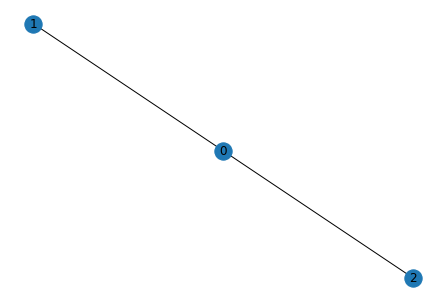

In [19]:
g = Network(l)
print(g.is_consensus())
g.plot()

In [95]:
g.describe()
print(g.is_consensus())
g.run_evidence_collection()
g.run_credence_update()
g.describe()
print(g.is_consensus())

- Agent 0, 0.9936481503774242, 10, 7, [1, 2]
- Agent 1, 0.9998307906465516, 10, 5, [0]
- Agent 2, 0.7533256365693816, 0, 0, [0]

False
- Agent 0, 0.9987388855485293, 10, 8, [1, 2]
- Agent 1, 0.9999247887726656, 10, 3, [0]
- Agent 2, 0.9873846997992822, 10, 6, [0]

False


### Simulation

In [96]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 3), (3, 4), (2, 5), (5, 6)])
l = nx.convert.to_dict_of_lists(G)
g = Network(l)
g.is_consensus()

s = Simulation(g, 10)
s.run()

False

In [98]:
s = Simulation(g, 10)
s.run()

- Agent 0, 0.9999999947041478, 10, 4, [1, 2]
- Agent 1, 0.9998499925031161, 10, 5, [0, 3]
- Agent 2, 0.999999998927444, 10, 5, [0, 5]
- Agent 3, 0.9996717369603754, 10, 4, [1, 4]
- Agent 4, 0.15903316352568994, 0, 0, [3]
- Agent 5, 0.9999999997277202, 10, 6, [2, 6]
- Agent 6, 0.9998604638279907, 10, 4, [5]



True

### Visualizations

In [164]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_sims_results(d, a_numbers):
    for s in d.keys():
        plt.plot(a_numbers, d[s], label = s)
    plt.xlabel('Nr agents in network')
    plt.ylabel('Probability of correct consensus')
    plt.title('Simulations for different network structures')
    plt.legend()
    plt.show()

### Zollman effect

In [184]:
MAX_STEPS = 10000

def test_complete(nr_nodes, nr_sims):
    g = nx.complete_graph(nr_nodes)
    l = nx.convert.to_dict_of_lists(g)
    res = []
    for i in range(nr_sims):
        n = Network(l)
        s = Simulation(n, MAX_STEPS)
        p_res = s.run()
        res.append(1 if p_res else 0)
    return np.mean(res)

def test_cycle(nr_nodes, nr_sims):
    g = nx.cycle_graph(nr_nodes)
    l = nx.convert.to_dict_of_lists(g)
    res = []
    for i in range(nr_sims):
        n = Network(l)
        s = Simulation(n, MAX_STEPS)
        p_res = s.run()
        res.append(1 if p_res else 0)
    return np.mean(res)

def test_wheel(nr_nodes, nr_sims):
    g = nx.wheel_graph(nr_nodes)
    l = nx.convert.to_dict_of_lists(g)
    res = []
    for i in range(nr_sims):
        n = Network(l)
        s = Simulation(n, MAX_STEPS)
        p_res = s.run()
        res.append(1 if p_res else 0)
    return np.mean(res)

In [185]:
import numpy as np

results = {
    'cycle': [],
    'wheel': [],
    'complete': []
}
agent_nrs = [5, 6, 7, 8, 9, 10]
sims_nr = 1000

for nr in agent_nrs:
    # Complete
    res = test_complete(nr, sims_nr)
    results['complete'].append(res)
    
    # Wheel
    res = test_wheel(nr, sims_nr)
    results['wheel'].append(res)
    
    # Cycle
    res = test_cycle(nr, sims_nr)
    results['cycle'].append(res)

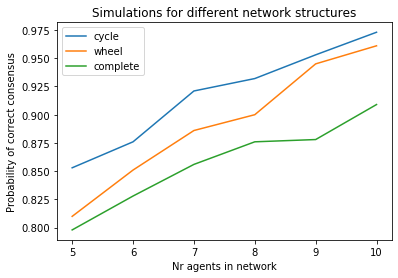

In [186]:
plot_sims_results(results, agent_nrs)

### Dynamic network

In [33]:
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (2, 3)])
l1 = nx.convert.to_dict_of_lists(G)
print(l1)
G.add_edges_from([(1, 2)])
l2 = nx.convert.to_dict_of_lists(G)
print(l2)
G.add_edges_from([(0, 3)])
l3 = nx.convert.to_dict_of_lists(G)
print(l3)

{0: [1, 2], 1: [0], 2: [0, 3], 3: [2]}
{0: [1, 2], 1: [0, 2], 2: [0, 3, 1], 3: [2]}
{0: [1, 2, 3], 1: [0, 2], 2: [0, 3, 1], 3: [2, 0]}


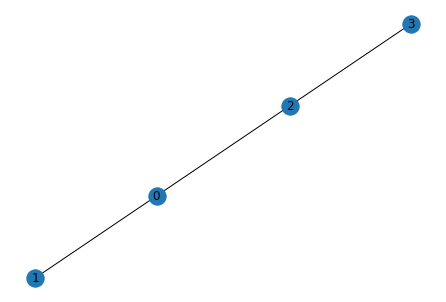

In [34]:
g = DynamicNetwork(l1)
g.plot()
g.update_structure(l2)
g.plot()

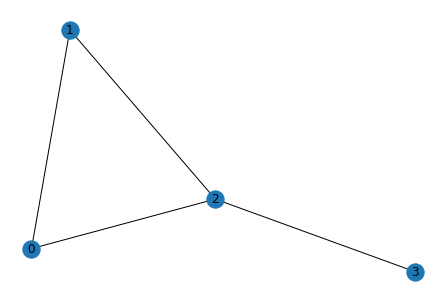

In [35]:
g.update_structure(l2)
g.plot()

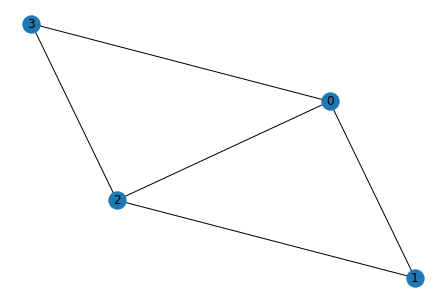

In [36]:
g.update_structure(l3)
g.plot()

# Mesa implementation

In [8]:
from mesa import Agent, Model
from mesa.time import RandomActivation

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        '''Advance the model by one step.'''
        self.schedule.step()

In [17]:
model = MoneyModel(1000)
for i in range(1000):
    model.step()

(array([461., 284., 143.,  63.,  25.,  15.,   3.,   1.,   4.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

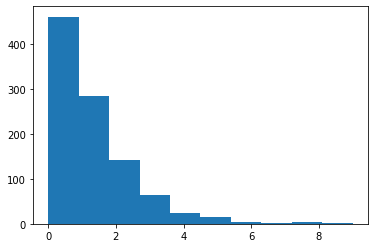

In [18]:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

# NetworkX usage

In [5]:
import networkx as nx

In [6]:
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3)])

In [8]:
G.number_of_nodes()

3

In [9]:
G.number_of_edges()

2

In [10]:
for line in nx.generate_adjlist(G):
    print(line)

1 2 3
2
3


In [18]:
from networkx.readwrite import json_graph
nx.convert.to_dict_of_lists(G)

{1: [2, 3], 2: [1], 3: [1]}